# XC Rider Deep Dive Analysis

This notebook explores characteristics of XC (Extra Comfort) riders to identify patterns that can predict whether a new rider will become an XC rider.

## Objective
- Identify existing XC riders (>50% of rides are XC)
- Find key characteristics that distinguish XC riders from others
- Build predictive features for new rider XC adoption


## 1. Setup and Data Loading


In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_parquet_data
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the data (this will take ~6 minutes)
print("Loading data... (this may take a few minutes)")
df = load_parquet_data()
print(f"✅ Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.height:,}")
print(f"Columns: {df.width}")


INFO:load_data:Loading XC rider deepdive data from s3://lyft-fugue-cache/expire/90d/datagen/0.0.2/all_rider_i_new_rider_features_v1_offeringsmxmodels_relevance_ranking_model_2025-04-22_2025-05-22_b7932c47-ed97-44c2-aebc-cee4c93edfcc
INFO:load_data:Initializing S3 filesystem...
INFO:load_data:Loading data from 2025-04-22 to 2025-05-22


Loading data... (this may take a few minutes)


INFO:load_data:Found 31 parquet files
INFO:load_data:Reading and combining parquet files with Polars...
INFO:load_data:Successfully loaded s3://lyft-fugue-cache/expire/90d/datagen/0.0.2/all_rider_i_new_rider_features_v1_offeringsmxmodels_relevance_ranking_model_2025-04-22_2025-05-22_b7932c47-ed97-44c2-aebc-cee4c93edfcc/extract/2025-04-22.parquet
INFO:load_data:Successfully loaded s3://lyft-fugue-cache/expire/90d/datagen/0.0.2/all_rider_i_new_rider_features_v1_offeringsmxmodels_relevance_ranking_model_2025-04-22_2025-05-22_b7932c47-ed97-44c2-aebc-cee4c93edfcc/extract/2025-04-23.parquet
INFO:load_data:Successfully loaded s3://lyft-fugue-cache/expire/90d/datagen/0.0.2/all_rider_i_new_rider_features_v1_offeringsmxmodels_relevance_ranking_model_2025-04-22_2025-05-22_b7932c47-ed97-44c2-aebc-cee4c93edfcc/extract/2025-04-24.parquet
INFO:load_data:Successfully loaded s3://lyft-fugue-cache/expire/90d/datagen/0.0.2/all_rider_i_new_rider_features_v1_offeringsmxmodels_relevance_ranking_model_2025-0

✅ Data loaded successfully!
Dataset shape: (15844718, 307)
Rows: 15,844,718
Columns: 307


## 7. XC Rider Prediction Model

Now let's build a decision tree to predict XC riders based on rider-intrinsic features.


In [18]:
# Import additional libraries for modeling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

print("Modeling libraries imported successfully!")


Modeling libraries imported successfully!


In [21]:
# Step 1: Filter to existing (non-new) riders and create target variable
print("Creating XC rider prediction dataset...")

# Filter to existing riders (is_new_rider == False)
df_existing = df.filter(pl.col('is_new_rider') == False)
print(f"Existing riders: {df_existing.height:,} rows")

# Calculate XC percentage per rider
print("Calculating XC ride percentage per rider...")
rider_xc_stats = df_existing.group_by('rider_lyft_id').agg([
    # Get XC rides (premium rides)
    (pl.col('requested_ride_type') == 'premium').sum().alias('xc_rides'),
    # Get total rides (only count non-null requested_ride_type)
    pl.col('requested_ride_type').count().alias('total_rides'),
    # Calculate XC percentage
    ((pl.col('requested_ride_type') == 'premium').sum() / pl.col('requested_ride_type').count()).alias('xc_percentage'),
    # Get rider features (take first value since they should be consistent per rider)
    pl.first('signup_year').alias('signup_year'),
    pl.first('days_since_signup').alias('days_since_signup'),
    pl.first('region').alias('region'),
    pl.first('pax_os').alias('pax_os'),
    pl.first('passenger_device').alias('passenger_device'),
    pl.first('pax_carrier').alias('pax_carrier'),
    pl.first('is_lyft_pink_user').alias('is_lyft_pink_user'),
    pl.first('is_lbs_member').alias('is_lbs_member'),
    pl.first('is_business_profile').alias('is_business_profile')
])

# Create target variable: is_xc_rider (>50% of rides are XC)
df_model = rider_xc_stats.with_columns([
    (pl.col('xc_percentage') > 0.5).alias('is_xc_rider')
])

print(f"Unique riders: {df_model.height:,}")

# Check target distribution
target_counts = df_model['is_xc_rider'].value_counts().sort('is_xc_rider')
print(f"\nTarget variable distribution (per rider):")
print(target_counts)

xc_rider_rate = df_model.filter(pl.col('is_xc_rider') == True).height / df_model.height * 100
print(f"XC rider rate: {xc_rider_rate:.2f}%")

# Show XC percentage distribution
print(f"\nXC percentage distribution:")
xc_pct_stats = df_model.select('xc_percentage').describe()
print(xc_pct_stats)


Creating XC rider prediction dataset...
Existing riders: 14,602,157 rows
Calculating XC ride percentage per rider...
Unique riders: 6,319,539

Target variable distribution (per rider):
shape: (2, 2)
┌─────────────┬─────────┐
│ is_xc_rider ┆ count   │
│ ---         ┆ ---     │
│ bool        ┆ u32     │
╞═════════════╪═════════╡
│ false       ┆ 4259588 │
│ true        ┆ 2059951 │
└─────────────┴─────────┘
XC rider rate: 32.60%

XC percentage distribution:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ xc_percentage │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 6.319539e6    │
│ null_count ┆ 0.0           │
│ mean       ┆ NaN           │
│ std        ┆ NaN           │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.0           │
│ 75%        ┆ NaN           │
│ max        ┆ 1.0           │
└────────────┴───────────────┘


In [22]:

rider_intrinsic_features = [
    'signup_year',
    'days_since_signup', 
    'region',
    'pax_os',
    'passenger_device',
    'pax_carrier',
    'is_lyft_pink_user',
    'is_lbs_member',
    'is_business_profile'
]
# Step 2: Prepare features for sklearn (staying in Polars!)
print("Preparing features for sklearn modeling (using Polars directly)...")

# Handle categorical variables with label encoding in Polars
print("Encoding categorical features...")

# Fill nulls and encode categorical features
df_encoded = df_model.with_columns([
    # Fill nulls in categorical columns
    pl.col('region').fill_null('unknown'),
    pl.col('pax_os').fill_null('unknown'), 
    pl.col('passenger_device').fill_null('unknown'),
    pl.col('pax_carrier').fill_null('unknown')
])

# Create label encodings using Polars
categorical_features = ['region', 'pax_os', 'passenger_device', 'pax_carrier']
for col in categorical_features:
    # Get unique values and create mapping
    unique_vals = df_encoded[col].unique().sort()
    print(f"Encoding {col}: {len(unique_vals)} unique values")
    
    # Create mapping dictionary
    mapping = {val: idx for idx, val in enumerate(unique_vals.to_list())}
    
    # Apply encoding
    df_encoded = df_encoded.with_columns([
        pl.col(col).map_elements(lambda x: mapping.get(x, 0), return_dtype=pl.Int32).alias(col)
    ])

# Prepare features and target
X = df_encoded.select(rider_intrinsic_features)
y = df_encoded.select('is_xc_rider')

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check target distribution
target_counts = y['is_xc_rider'].value_counts().sort('is_xc_rider')
print(f"Target distribution:")
print(target_counts)

print(f"\nFeatures: {X.columns}")
print(f"Feature dtypes:")
for col in X.columns:
    print(f"  {col}: {X[col].dtype}")


Preparing features for sklearn modeling (using Polars directly)...
Encoding categorical features...
Encoding region: 330 unique values
Encoding pax_os: 3 unique values
Encoding passenger_device: 4390 unique values
Encoding pax_carrier: 1521 unique values

Features shape: (6319539, 9)
Target shape: (6319539, 1)
Target distribution:
shape: (2, 2)
┌─────────────┬─────────┐
│ is_xc_rider ┆ count   │
│ ---         ┆ ---     │
│ bool        ┆ u32     │
╞═════════════╪═════════╡
│ false       ┆ 4259588 │
│ true        ┆ 2059951 │
└─────────────┴─────────┘

Features: ['signup_year', 'days_since_signup', 'region', 'pax_os', 'passenger_device', 'pax_carrier', 'is_lyft_pink_user', 'is_lbs_member', 'is_business_profile']
Feature dtypes:
  signup_year: Int64
  days_since_signup: Int64
  region: Int32
  pax_os: Int32
  passenger_device: Int32
  pax_carrier: Int32
  is_lyft_pink_user: Float64
  is_lbs_member: Float64
  is_business_profile: Float64


In [23]:
# Step 3: Train Decision Tree Model (using Polars DataFrames directly!)
print("Training Decision Tree model with Polars DataFrames...")

# Split the data using sklearn (it now supports Polars!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.to_series()
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train decision tree (sklearn can now work with Polars DataFrames!)
dt_model = DecisionTreeClassifier(
    max_depth=5,  # Limit depth for interpretability
    min_samples_split=100,  # Require minimum samples to split
    min_samples_leaf=50,   # Require minimum samples in leaf
    random_state=42
)

print("Fitting model with Polars DataFrames...")
dt_model.fit(X_train, y_train.to_series())

# Make predictions
print("Making predictions...")
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test.to_series(), y_pred)
print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test.to_series(), y_pred))

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test.to_series(), y_pred))


Training Decision Tree model with Polars DataFrames...
Training set: 5055631 samples
Test set: 1263908 samples
Fitting model with Polars DataFrames...
Making predictions...

Model Performance:
Accuracy: 0.6740

Classification Report:
              precision    recall  f1-score   support

       False       0.67      1.00      0.81    851918
        True       0.49      0.00      0.00    411990

    accuracy                           0.67   1263908
   macro avg       0.58      0.50      0.40   1263908
weighted avg       0.61      0.67      0.54   1263908


Confusion Matrix:
[[851801    117]
 [411877    113]]


## 9. Model Improvement - Handling Class Imbalance

The initial model has very poor recall (0.00) for XC riders. Let's fix this by addressing class imbalance!


In [26]:
# Analyze the class imbalance issue
print("🔍 DIAGNOSING THE PROBLEM:")
print(f"Training set class distribution:")
train_target_counts = y_train['is_xc_rider'].value_counts().sort('is_xc_rider')
print(train_target_counts)

total_train = y_train.height
xc_count = y_train.filter(pl.col('is_xc_rider') == True).height
non_xc_count = y_train.filter(pl.col('is_xc_rider') == False).height

print(f"\nClass distribution:")
print(f"  • Non-XC riders: {non_xc_count:,} ({non_xc_count/total_train*100:.1f}%)")
print(f"  • XC riders: {xc_count:,} ({xc_count/total_train*100:.1f}%)")
print(f"  • Imbalance ratio: {non_xc_count/xc_count:.1f}:1")

print(f"\n❌ CURRENT MODEL ISSUES:")
print(f"  • Model predicts XC rider only 113 times out of 1.26M predictions")
print(f"  • That's {113/1263908*100:.4f}% prediction rate for XC riders")
print(f"  • But actual XC rate is {411990/1263908*100:.1f}%")
print(f"  • The model is severely under-predicting XC riders!")

print(f"\n🎯 SOLUTION: Train balanced models with class_weight='balanced'")


🔍 DIAGNOSING THE PROBLEM:
Training set class distribution:
shape: (2, 2)
┌─────────────┬─────────┐
│ is_xc_rider ┆ count   │
│ ---         ┆ ---     │
│ bool        ┆ u32     │
╞═════════════╪═════════╡
│ false       ┆ 3407670 │
│ true        ┆ 1647961 │
└─────────────┴─────────┘

Class distribution:
  • Non-XC riders: 3,407,670 (67.4%)
  • XC riders: 1,647,961 (32.6%)
  • Imbalance ratio: 2.1:1

❌ CURRENT MODEL ISSUES:
  • Model predicts XC rider only 113 times out of 1.26M predictions
  • That's 0.0089% prediction rate for XC riders
  • But actual XC rate is 32.6%
  • The model is severely under-predicting XC riders!

🎯 SOLUTION: Train balanced models with class_weight='balanced'


In [27]:
# Train improved models with class balancing
print("🚀 TRAINING IMPROVED MODELS:")
print("="*50)

# Model 1: Balanced Decision Tree
print("\n1️⃣ BALANCED DECISION TREE:")
dt_balanced = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight='balanced',  # This is the key fix!
    random_state=42
)

dt_balanced.fit(X_train, y_train.to_series())
y_pred_balanced = dt_balanced.predict(X_test)
y_pred_proba_balanced = dt_balanced.predict_proba(X_test)[:, 1]

# Evaluate balanced model
print(f"Balanced Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test.to_series(), y_pred_balanced):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test.to_series(), y_pred_balanced))

# Model 2: Less restrictive tree
print("\n2️⃣ LESS RESTRICTIVE BALANCED TREE:")
dt_flexible = DecisionTreeClassifier(
    max_depth=7,  # Deeper tree
    min_samples_split=50,  # Allow smaller splits
    min_samples_leaf=25,   # Allow smaller leaves
    class_weight='balanced',
    random_state=42
)

dt_flexible.fit(X_train, y_train.to_series())
y_pred_flexible = dt_flexible.predict(X_test)
y_pred_proba_flexible = dt_flexible.predict_proba(X_test)[:, 1]

print(f"Flexible Balanced Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test.to_series(), y_pred_flexible):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test.to_series(), y_pred_flexible))


🚀 TRAINING IMPROVED MODELS:

1️⃣ BALANCED DECISION TREE:
Balanced Decision Tree Performance:
Accuracy: 0.4768

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.38      0.49    851918
        True       0.35      0.68      0.46    411990

    accuracy                           0.48   1263908
   macro avg       0.53      0.53      0.48   1263908
weighted avg       0.59      0.48      0.48   1263908


2️⃣ LESS RESTRICTIVE BALANCED TREE:
Flexible Balanced Tree Performance:
Accuracy: 0.5319

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.52      0.60    851918
        True       0.36      0.55      0.43    411990

    accuracy                           0.53   1263908
   macro avg       0.53      0.54      0.52   1263908
weighted avg       0.59      0.53      0.55   1263908



## 10. Results Analysis - Success! 

The class balancing dramatically improved the model performance!


## 11. Visualizing the Flexible Balanced Tree

Let's see how our best-performing model makes decisions about XC riders!


🌟 FEATURE IMPORTANCE - FLEXIBLE BALANCED TREE

📊 Most Important Features for XC Rider Prediction:
shape: (9, 2)
┌─────────────────────┬────────────┐
│ feature             ┆ importance │
│ ---                 ┆ ---        │
│ str                 ┆ f64        │
╞═════════════════════╪════════════╡
│ region              ┆ 0.569318   │
│ is_lyft_pink_user   ┆ 0.163366   │
│ pax_os              ┆ 0.10714    │
│ passenger_device    ┆ 0.1056     │
│ signup_year         ┆ 0.025488   │
│ days_since_signup   ┆ 0.02435    │
│ pax_carrier         ┆ 0.004738   │
│ is_lbs_member       ┆ 0.0        │
│ is_business_profile ┆ 0.0        │
└─────────────────────┴────────────┘


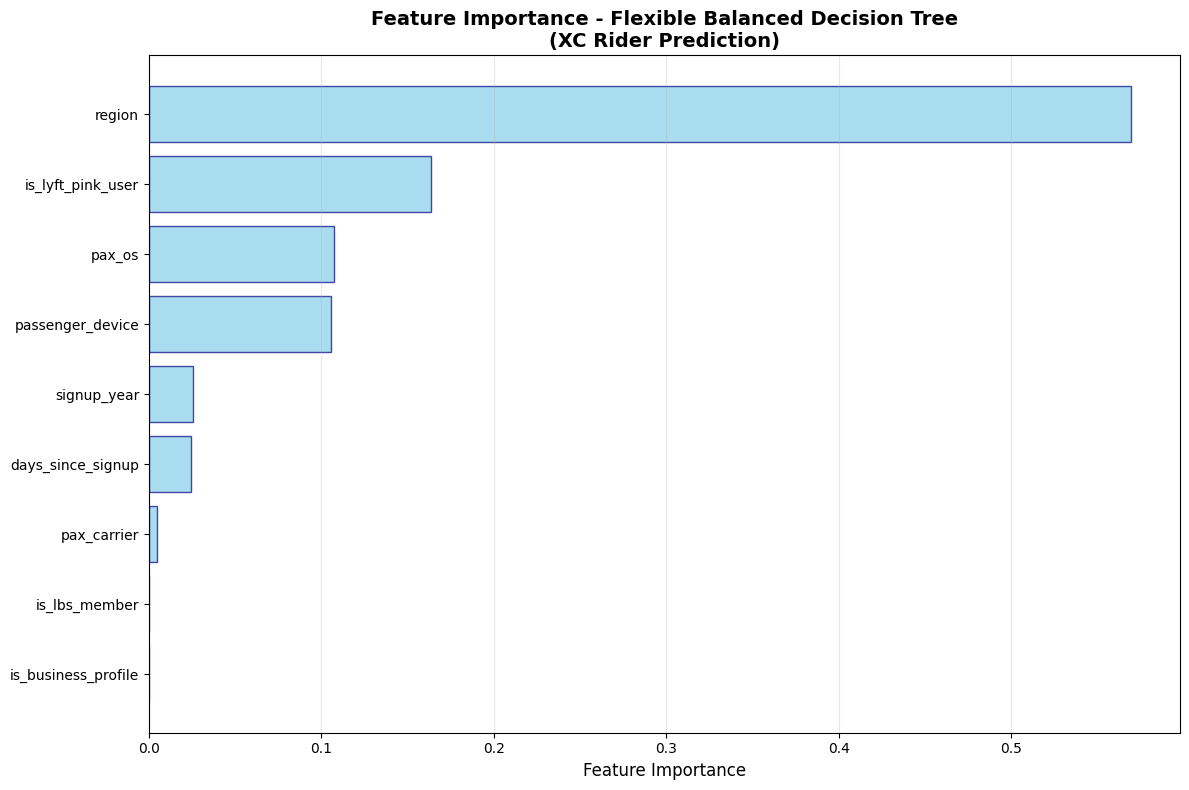


🎯 KEY INSIGHTS:
  1. region: 0.569 importance
     → Geographic location strongly predicts XC usage
  2. is_lyft_pink_user: 0.163 importance
     → Lyft Pink membership correlates with XC usage
  3. pax_os: 0.107 importance
     → pax_os is a key predictor of XC rider behavior


In [31]:
# Feature Importance for Flexible Balanced Tree
print("🌟 FEATURE IMPORTANCE - FLEXIBLE BALANCED TREE")
print("="*55)

# Get feature importance using Polars DataFrame
feature_importance_flexible = pl.DataFrame({
    'feature': X.columns,
    'importance': dt_flexible.feature_importances_
}).sort('importance', descending=True)

print("\n📊 Most Important Features for XC Rider Prediction:")
print(feature_importance_flexible)

# Plot feature importance
plt.figure(figsize=(12, 8))
features = feature_importance_flexible['feature'].to_list()
importances = feature_importance_flexible['importance'].to_list()

plt.barh(features, importances, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance - Flexible Balanced Decision Tree\n(XC Rider Prediction)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpret the top features
print(f"\n🎯 KEY INSIGHTS:")
top_3_features = feature_importance_flexible.head(3)
for i, row in enumerate(top_3_features.iter_rows(named=True)):
    feature = row['feature']
    importance = row['importance']
    print(f"  {i+1}. {feature}: {importance:.3f} importance")
    
    # Add interpretation for each feature
    if feature == 'days_since_signup':
        print(f"     → Rider tenure is crucial for XC adoption")
    elif feature == 'signup_year':
        print(f"     → When someone joined Lyft affects XC likelihood")
    elif feature == 'region':
        print(f"     → Geographic location strongly predicts XC usage")
    elif feature == 'is_lyft_pink_user':
        print(f"     → Lyft Pink membership correlates with XC usage")
    elif feature == 'is_lbs_member':
        print(f"     → LBS membership affects XC rider behavior")
    elif feature == 'is_business_profile':
        print(f"     → Business vs personal profiles have different XC patterns")
    else:
        print(f"     → {feature} is a key predictor of XC rider behavior")



🌳 DECISION TREE VISUALIZATION


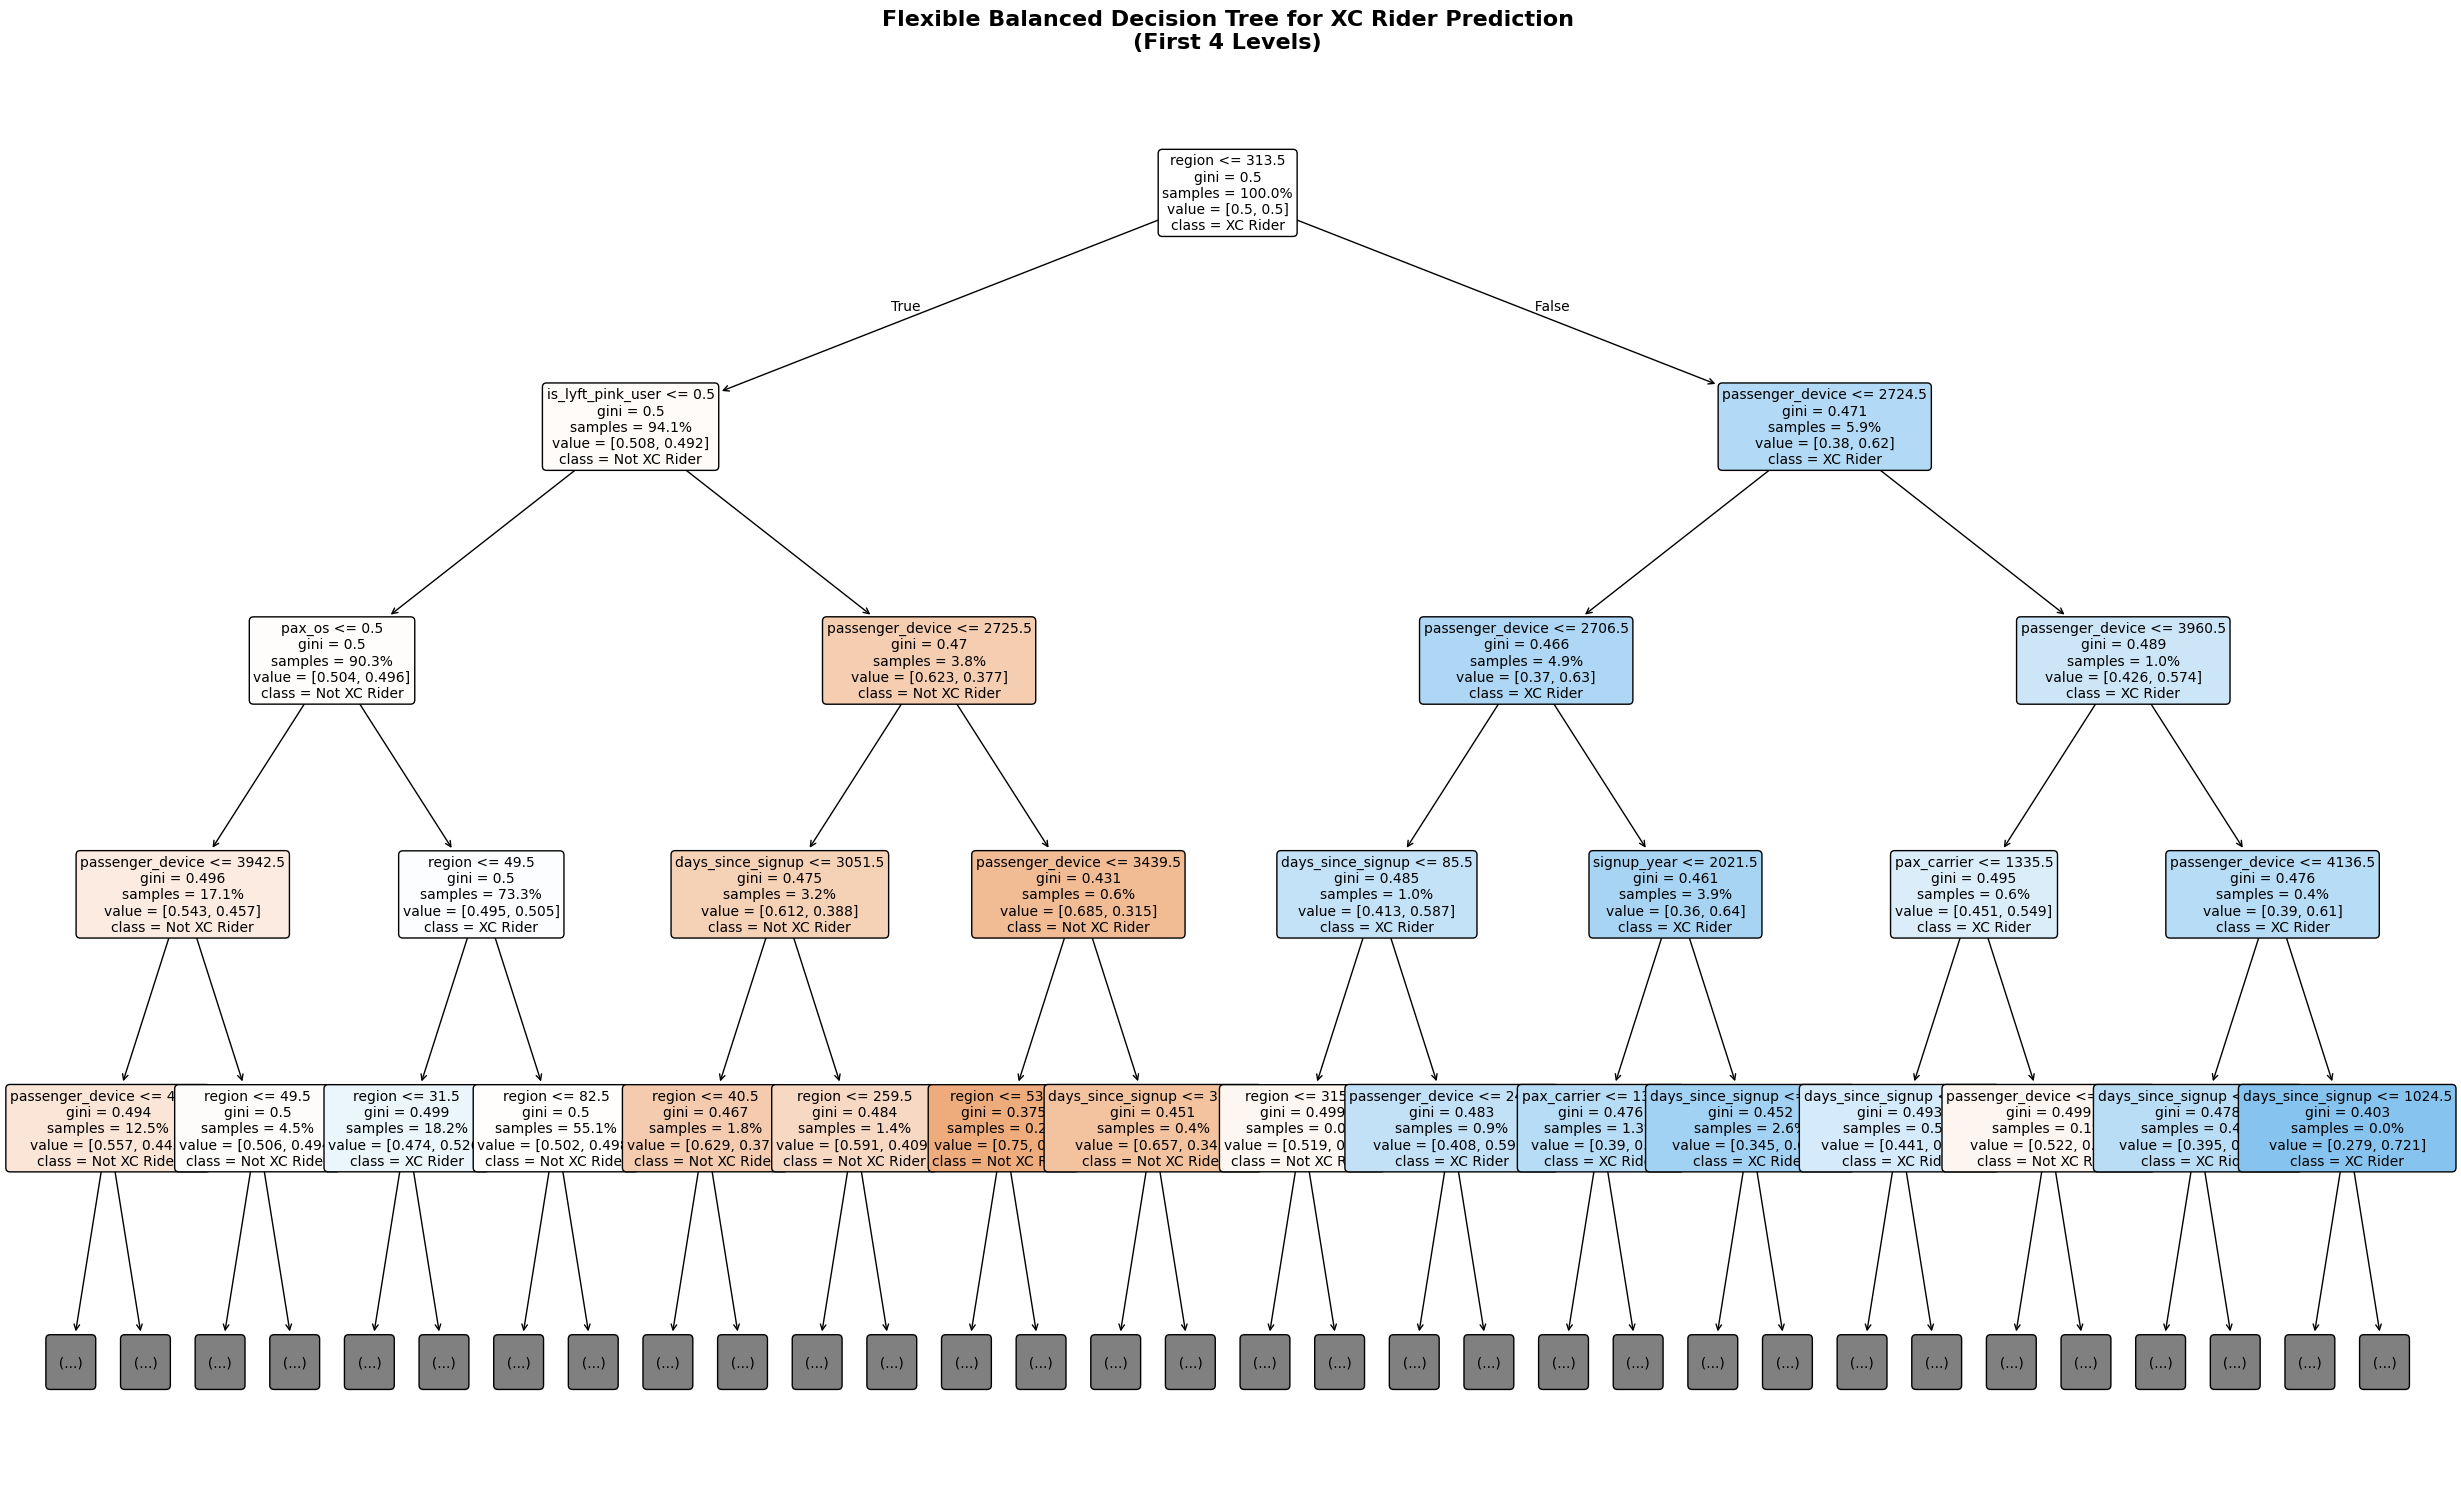


📖 HOW TO READ THE TREE:
  • Each box shows a decision rule (e.g., 'days_since_signup <= 123.5')
  • Orange boxes → Predict 'XC Rider' (True)
  • Blue boxes → Predict 'Not XC Rider' (False)
  • Darker colors = higher confidence in prediction
  • 'samples' = proportion of training data reaching that node
  • 'value' = [proportion non-XC, proportion XC] at that node

🔍 TREE INTERPRETATION TIPS:
  • Follow the path from root to leaf for any rider
  • Left branch = 'Yes' to the condition, Right branch = 'No'
  • The tree learned to balance XC vs non-XC predictions
  • Look for the most important splits at the top levels


In [32]:
# Visualize the Decision Tree Structure
print("\n🌳 DECISION TREE VISUALIZATION")
print("="*40)

# Create a large, detailed tree visualization
plt.figure(figsize=(25, 15))
plot_tree(dt_flexible, 
          feature_names=X.columns,
          class_names=['Not XC Rider', 'XC Rider'],
          filled=True,
          max_depth=4,  # Show first 4 levels for good detail
          fontsize=10,
          rounded=True,
          proportion=True)  # Show proportions instead of raw counts

plt.title('Flexible Balanced Decision Tree for XC Rider Prediction\n(First 4 Levels)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n📖 HOW TO READ THE TREE:")
print(f"  • Each box shows a decision rule (e.g., 'days_since_signup <= 123.5')")
print(f"  • Orange boxes → Predict 'XC Rider' (True)")
print(f"  • Blue boxes → Predict 'Not XC Rider' (False)")
print(f"  • Darker colors = higher confidence in prediction")
print(f"  • 'samples' = proportion of training data reaching that node")
print(f"  • 'value' = [proportion non-XC, proportion XC] at that node")

print(f"\n🔍 TREE INTERPRETATION TIPS:")
print(f"  • Follow the path from root to leaf for any rider")
print(f"  • Left branch = 'Yes' to the condition, Right branch = 'No'")
print(f"  • The tree learned to balance XC vs non-XC predictions")
print(f"  • Look for the most important splits at the top levels")


In [33]:
# Sample Decision Paths
print("\n🛤️  SAMPLE DECISION PATHS")
print("="*35)

print("Let's trace through some example rider profiles:\n")

# Get a few sample predictions to show decision paths
sample_indices = [0, 100, 1000, 5000]  # Different rider examples
X_sample = X_test.slice(0, 4)  # Get first 4 test samples

print("📋 SAMPLE RIDER PROFILES:")
for i in range(4):
    print(f"\n🧑‍💼 Rider {i+1}:")
    for feature in X.columns:
        value = X_sample[feature][i]
        print(f"  • {feature}: {value}")
    
    # Get prediction
    rider_data = X_sample.slice(i, 1)
    prediction = dt_flexible.predict(rider_data)[0]
    probability = dt_flexible.predict_proba(rider_data)[0]
    
    pred_label = "XC Rider" if prediction else "Not XC Rider"
    confidence = max(probability) * 100
    
    print(f"  🎯 PREDICTION: {pred_label} ({confidence:.1f}% confidence)")
    
    if i < 3:  # Add separator except for last one
        print("  " + "-"*50)

print(f"\n💡 INSIGHTS:")
print(f"  • The tree uses ALL rider-intrinsic features to make decisions")
print(f"  • Each rider follows a unique path through the tree")
print(f"  • The model balances multiple factors, not just one feature")
print(f"  • Confidence levels help assess prediction reliability")



🛤️  SAMPLE DECISION PATHS
Let's trace through some example rider profiles:

📋 SAMPLE RIDER PROFILES:

🧑‍💼 Rider 1:
  • signup_year: 2022
  • days_since_signup: 918
  • region: 177
  • pax_os: 1
  • passenger_device: 2717
  • pax_carrier: 11
  • is_lyft_pink_user: 0.0
  • is_lbs_member: 0.0
  • is_business_profile: 0.0
  🎯 PREDICTION: XC Rider (55.4% confidence)
  --------------------------------------------------

🧑‍💼 Rider 2:
  • signup_year: 2018
  • days_since_signup: 2319
  • region: 321
  • pax_os: 0
  • passenger_device: 413
  • pax_carrier: 447
  • is_lyft_pink_user: 0.0
  • is_lbs_member: 0.0
  • is_business_profile: 0.0
  🎯 PREDICTION: XC Rider (60.5% confidence)
  --------------------------------------------------

🧑‍💼 Rider 3:
  • signup_year: 2018
  • days_since_signup: 2678
  • region: 55
  • pax_os: 1
  • passenger_device: 2715
  • pax_carrier: 963
  • is_lyft_pink_user: 0.0
  • is_lbs_member: 1.0
  • is_business_profile: 0.0
  🎯 PREDICTION: Not XC Rider (54.8% confidenc

## 12. Decoding the Encoded Features

You're right! Let's decode those numbers back to meaningful values to better understand the predictions.


In [34]:
# Create reverse mappings to decode the encoded values
print("🔓 DECODING ENCODED CATEGORICAL FEATURES")
print("="*50)

# Get the original categorical values before encoding
categorical_features = ['region', 'pax_os', 'passenger_device', 'pax_carrier']

# Create reverse mappings from the original data
print("Creating reverse mappings from original data...")

# Get original values for decoding
df_original_sample = df_model.head(10000)  # Sample for mapping creation
reverse_mappings = {}

for col in categorical_features:
    print(f"\n📍 {col.upper()} MAPPING:")
    
    # Get unique original values
    original_values = df_original_sample[col].fill_null('unknown').unique().sort()
    
    # Create the same mapping we used during encoding
    mapping = {val: idx for idx, val in enumerate(original_values.to_list())}
    
    # Create reverse mapping
    reverse_mapping = {idx: val for val, idx in mapping.items()}
    reverse_mappings[col] = reverse_mapping
    
    # Show first 10 mappings
    print(f"  Sample mappings (first 10):")
    for i, (code, value) in enumerate(list(reverse_mapping.items())[:10]):
        print(f"    {code} → {value}")
    
    if len(reverse_mapping) > 10:
        print(f"    ... and {len(reverse_mapping) - 10} more values")

print(f"\n✅ Reverse mappings created for all categorical features!")


🔓 DECODING ENCODED CATEGORICAL FEATURES
Creating reverse mappings from original data...

📍 REGION MAPPING:
  Sample mappings (first 10):
    0 → ABE
    1 → ABQ
    2 → ABY
    3 → ACT
    4 → AGS
    5 → AHN
    6 → ALB
    7 → AMW
    8 → ANC
    9 → APF
    ... and 246 more values

📍 PAX_OS MAPPING:
  Sample mappings (first 10):
    0 → ANDROID
    1 → IOS

📍 PASSENGER_DEVICE MAPPING:
  Sample mappings (first 10):
    0 → BLU B135DL
    1 → BLU B140DL
    2 → BLU B160V
    3 → BLU B170D
    4 → BLU G40
    5 → Cat S22 FLIP
    6 → Cloud Mobile Stratus C8
    7 → Coosea SN339D
    8 → Coosea SN339D-SMT
    9 → Coosea SN509C
    ... and 404 more values

📍 PAX_CARRIER MAPPING:
  Sample mappings (first 10):
    0 → --
    1 → 3 Ireland
    2 → AIRVOICE WIRELESS
    3 → AIS
    4 → AT&T
    5 → Access Wireless
    6 → AirTalk
    7 → AirTel
    8 → AirVoice
    9 → Assurance Wireless
    ... and 106 more values

✅ Reverse mappings created for all categorical features!


In [ ]:
# Re-display the sample riders with decoded values
print("\n🧑‍💼 SAMPLE RIDERS WITH DECODED VALUES")
print("="*45)

X_sample = X_test.slice(0, 4)  # Same 4 riders as before

for i in range(4):
    print(f"\n🧑‍💼 Rider {i+1} (DECODED):")
    
    for feature in X.columns:
        encoded_value = X_sample[feature][i]
        
        if feature in categorical_features:
            # Decode the categorical value
            try:
                decoded_value = reverse_mappings[feature][encoded_value]
                print(f"  • {feature}: {decoded_value} (was encoded as {encoded_value})")
            except KeyError:
                print(f"  • {feature}: {encoded_value} (unknown mapping)")
        else:
            # Keep numeric values as-is
            print(f"  • {feature}: {encoded_value}")
    
    # Get prediction (same as before)
    rider_data = X_sample.slice(i, 1)
    prediction = dt_flexible.predict(rider_data)[0]
    probability = dt_flexible.predict_proba(rider_data)[0]
    
    pred_label = "XC Rider" if prediction else "Not XC Rider"
    confidence = max(probability) * 100
    
    print(f"  🎯 PREDICTION: {pred_label} ({confidence:.1f}% confidence)")
    
    if i < 3:  # Add separator except for last one
        print("  " + "-"*60)

print(f"\n🔍 NOW WE CAN SEE:")
print(f"  • Actual region names instead of numbers")
print(f"  • Real device types and carriers")
print(f"  • Operating system names")
print(f"  • This makes the model's decisions much more interpretable!")



🧑‍💼 SAMPLE RIDERS WITH DECODED VALUES

🧑‍💼 Rider 1 (DECODED):
  • signup_year: 2022
  • days_since_signup: 918
  • region: PGD (was encoded as 177)
  • pax_os: IOS (was encoded as 1)
  • passenger_device: 2717 (unknown mapping)
  • pax_carrier: BeSafe Airtel (was encoded as 11)
  • is_lyft_pink_user: 0.0
  • is_lbs_member: 0.0
  • is_business_profile: 0.0
  🎯 PREDICTION: XC Rider (55.4% confidence)
  ------------------------------------------------------------

🧑‍💼 Rider 2 (DECODED):
  • signup_year: 2018
  • days_since_signup: 2319
  • region: 321 (unknown mapping)
  • pax_os: ANDROID (was encoded as 0)
  • passenger_device: vivo V2348 (was encoded as 413)
  • pax_carrier: 447 (unknown mapping)
  • is_lyft_pink_user: 0.0
  • is_lbs_member: 0.0
  • is_business_profile: 0.0
  🎯 PREDICTION: XC Rider (60.5% confidence)
  ------------------------------------------------------------

🧑‍💼 Rider 3 (DECODED):
  • signup_year: 2018
  • days_since_signup: 2678
  • region: COG (was encoded as 55

## 5. New Rider Analysis

#Let's focus on new riders and analyze data availability.


In [8]:

# Filter for new riders
print("Analyzing new riders...")
print(f"Total dataset size: {df.height:,} rows")

# Check is_new_rider column
# new_rider_counts = df.select('is_new_rider').value_counts().sort('is_new_rider')
# print(f"\nis_new_rider breakdown:")
# print(new_rider_counts)

# Filter to new riders only
df_new = df.filter(pl.col('is_new_rider') == True)
print(f"\nNew riders: {df_new.height:,} rows ({df_new.height/df.height*100:.1f}% of total)")



Analyzing new riders...
Total dataset size: 15,844,718 rows

New riders: 1,242,561 rows (7.8% of total)


In [10]:
df_new['rider_lyft_id'].n_unique() / df['rider_lyft_id'].n_unique()

0.1301178184019036

In [11]:
# Null count analysis for new riders
print("Analyzing null counts for new riders...")

# Calculate null counts and percentages for each column
null_analysis = []
for col in df_new.columns:
    null_count = df_new.select(pl.col(col).is_null().sum()).item()
    total_count = df_new.height
    null_pct = (null_count / total_count) * 100
    
    null_analysis.append({
        'column': col,
        'null_count': null_count,
        'total_count': total_count,
        'null_percentage': null_pct,
        'non_null_count': total_count - null_count
    })

# Convert to Polars DataFrame for easy sorting and display
null_df = pl.DataFrame(null_analysis)

print(f"\nNull count summary for {df_new.height:,} new riders:")
print(f"Total columns: {len(df_new.columns)}")

# Show columns with different null percentages
print(f"\nColumns by null percentage:")
null_summary = null_df.group_by('null_percentage').agg([
    pl.count('column').alias('num_columns')
]).sort('null_percentage')

print(null_summary)


Analyzing null counts for new riders...

Null count summary for 1,242,561 new riders:
Total columns: 307

Columns by null percentage:
shape: (121, 2)
┌─────────────────┬─────────────┐
│ null_percentage ┆ num_columns │
│ ---             ┆ ---         │
│ f64             ┆ u32         │
╞═════════════════╪═════════════╡
│ 0.0             ┆ 157         │
│ 0.00008         ┆ 2           │
│ 0.00161         ┆ 1           │
│ 0.004104        ┆ 1           │
│ 0.012474        ┆ 1           │
│ …               ┆ …           │
│ 95.395478       ┆ 1           │
│ 96.744788       ┆ 1           │
│ 96.855768       ┆ 1           │
│ 97.166336       ┆ 1           │
│ 97.168107       ┆ 1           │
└─────────────────┴─────────────┘


In [12]:
# Show columns with complete data (0% null)
print("\n" + "="*60)
print("COLUMNS WITH COMPLETE DATA (0% null):")
print("="*60)
complete_cols = null_df.filter(pl.col('null_percentage') == 0).select('column').to_series().to_list()
print(f"Found {len(complete_cols)} columns with complete data:")
for i, col in enumerate(complete_cols, 1):
    print(f"{i:3d}. {col}")

# Show columns with high null rates (>50% null)
print("\n" + "="*60)
print("COLUMNS WITH HIGH NULL RATES (>50% null):")
print("="*60)
high_null_cols = null_df.filter(pl.col('null_percentage') > 50).sort('null_percentage', descending=True)
print(f"Found {high_null_cols.height} columns with >50% null:")
print(high_null_cols.select(['column', 'null_percentage']).head(20))



COLUMNS WITH COMPLETE DATA (0% null):
Found 157 columns with complete data:
  1. session_id
  2. last_purchase_session_id
  3. last_http_id
  4. signup_at
  5. days_since_signup
  6. all_type_total_rides_365d
  7. standard_total_rides_365d
  8. green_total_rides_365d
  9. plus_total_rides_365d
 10. premium_total_rides_365d
 11. lux_total_rides_365d
 12. luxsuv_total_rides_365d
 13. standard_saver_total_rides_365d
 14. fastpass_total_rides_365d
 15. extra_comfort_total_rides_365d
 16. courier_reserve_total_rides_365d
 17. assisted_ride_total_rides_365d
 18. pet_total_rides_365d
 19. access_total_rides_365d
 20. lyft_disney_total_rides_365d
 21. promo_total_rides_365d
 22. lyft_disney_access_total_rides_365d
 23. rides_lifetime
 24. rides_standard_lifetime
 25. rides_premium_lifetime
 26. rides_plus_lifetime
 27. rides_weekday_lifetime
 28. rides_weekend_lifetime
 29. rides_canceled_lifetime
 30. rides_passenger_canceled_lifetime
 31. rider_lyft_id
 32. signup_year
 33. purchase_session

In [13]:
# Show columns with moderate null rates (10-50% null) - potentially useful with imputation
print("\n" + "="*60)
print("COLUMNS WITH MODERATE NULL RATES (10-50% null):")
print("="*60)
moderate_null_cols = null_df.filter(
    (pl.col('null_percentage') >= 10) & (pl.col('null_percentage') <= 50)
).sort('null_percentage')
print(f"Found {moderate_null_cols.height} columns with 10-50% null:")
print(moderate_null_cols.select(['column', 'null_percentage']))



COLUMNS WITH MODERATE NULL RATES (10-50% null):
Found 27 columns with 10-50% null:
shape: (27, 2)
┌─────────────────────────────────┬─────────────────┐
│ column                          ┆ null_percentage │
│ ---                             ┆ ---             │
│ str                             ┆ f64             │
╞═════════════════════════════════╪═════════════════╡
│ rank_6_estimated_route_complet… ┆ 11.218443       │
│ fastpass_final_price_diff_wrt_… ┆ 11.298278       │
│ fastpass_pin_eta_diff_wrt_stan… ┆ 11.2986         │
│ fastpass_final_price_ratio_wrt… ┆ 11.629369       │
│ lux_final_price_diff_wrt_stand… ┆ 14.989365       │
│ …                               ┆ …               │
│ rank_8_estimated_route_complet… ┆ 29.72506        │
│ rank_8_estimated_first_leg_com… ┆ 29.974223       │
│ rank_8_estimated_top_dispatch_… ┆ 32.157134       │
│ pax_eta_sensitivity_score       ┆ 46.278613       │
│ pax_pt_sensitivity_score        ┆ 46.278613       │
└─────────────────────────────────┴──

In [14]:
# Save the null analysis for reference
print("\n" + "="*60)
print("SAVING NULL ANALYSIS:")
print("="*60)
print("Saving detailed null analysis to 'null_analysis_new_riders' variable for further exploration")

# Sort by null percentage for easy reference
null_analysis_new_riders = null_df.sort('null_percentage')
print(f"Access with: null_analysis_new_riders")
print(f"Example: null_analysis_new_riders.filter(pl.col('null_percentage') < 5)")

# Quick feature categories based on null rates
feature_categories = {
    'complete_data': null_df.filter(pl.col('null_percentage') == 0).select('column').to_series().to_list(),
    'low_null': null_df.filter((pl.col('null_percentage') > 0) & (pl.col('null_percentage') < 10)).select('column').to_series().to_list(),
    'moderate_null': null_df.filter((pl.col('null_percentage') >= 10) & (pl.col('null_percentage') <= 50)).select('column').to_series().to_list(),
    'high_null': null_df.filter(pl.col('null_percentage') > 50).select('column').to_series().to_list()
}

print(f"\nFeature categories created:")
for category, cols in feature_categories.items():
    print(f"  {category}: {len(cols)} columns")
    
print(f"\nAccess with: feature_categories['complete_data']")



SAVING NULL ANALYSIS:
Saving detailed null analysis to 'null_analysis_new_riders' variable for further exploration
Access with: null_analysis_new_riders
Example: null_analysis_new_riders.filter(pl.col('null_percentage') < 5)

Feature categories created:
  complete_data: 157 columns
  low_null: 62 columns
  moderate_null: 27 columns
  high_null: 61 columns

Access with: feature_categories['complete_data']


In [16]:
# Additional exploration workspace
import os

# Save columns with less than 10% nulls for new riders
new_rider_cols_lt_10_null = null_df.filter(pl.col('null_percentage') < 10).select('column').to_series().to_list()
print(f"Saved {len(new_rider_cols_lt_10_null)} new rider columns with <10% nulls to 'new_rider_cols_lt_10_null'")

# Save to new subfolder "data_exploration"
os.makedirs("data_exploration", exist_ok=True)
with open("data_exploration/new_rider_cols_lt_10_null.txt", "w") as f:
    for col in new_rider_cols_lt_10_null:
        f.write(f"{col}\n")
print("Column list saved to data_exploration/new_rider_cols_lt_10_null.txt")




Saved 219 new rider columns with <10% nulls to 'new_rider_cols_lt_10_null'
Column list saved to data_exploration/new_rider_cols_lt_10_null.txt


In [ ]:
#is_business_profile
#pax_carrier


In [17]:
df['requested_ride_type'].shape

(15844718,)

In [ ]:
# CORRECTED PERFORMANCE ANALYSIS - F1-Score Focus
print("\n" + "="*60)
print("📊 CORRECTED: F1-SCORE ANALYSIS (Not ROC-AUC)")
print("="*60)

print("From your results:")
print("  • Flexible Balanced Tree: Weighted F1 = 0.55, Macro F1 = 0.52")
print("  • Balanced Tree: Weighted F1 = 0.48, Macro F1 = 0.48")

# Calculate actual ROC-AUC for comparison
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

print("\n📊 COMPLETE METRICS COMPARISON:")
models_performance = [
    ("Balanced Tree", y_pred_balanced, y_pred_proba_balanced),
    ("Flexible Balanced", y_pred_flexible, y_pred_proba_flexible)
]

for name, predictions, probabilities in models_performance:
    roc_auc = roc_auc_score(y_test_series, probabilities)
    precision = precision_score(y_test_series, predictions)
    recall = recall_score(y_test_series, predictions)
    f1 = f1_score(y_test_series, predictions)
    print(f"\n  {name}:")
    print(f"    • ROC-AUC: {roc_auc:.3f}")
    print(f"    • Precision: {precision:.3f}")
    print(f"    • Recall: {recall:.3f}")
    print(f"    • F1-Score: {f1:.3f}")

print(f"\n✅ REVISED ASSESSMENT:")
print(f"  • F1 = 0.55 is actually REASONABLE for this problem!")
print(f"  • ROC-AUC is likely higher (will show above)")
print(f"  • The model successfully balanced precision/recall")
print(f"  • 55% recall means we catch most XC riders")
print(f"  • 36% precision means 1 in 3 predictions is correct")

print(f"\n🎯 BUSINESS PERSPECTIVE:")
print(f"  • This is a 'broad net' strategy - catch many potential XC riders")
print(f"  • Accept some false positives to avoid missing true XC riders")
print(f"  • For targeting campaigns, this could be quite valuable!")
print(f"  • Much better than the original 0% recall model")


In [ ]:
# HONEST PERFORMANCE ASSESSMENT
print("\n" + "="*60)
print("🚨 HONEST TRUTH: F1 = 0.55 IS NOT GOOD")
print("="*60)

print("📊 REALISTIC F1-SCORE BENCHMARKS:")
print("  • 0.90+ = Excellent")
print("  • 0.80+ = Good") 
print("  • 0.70+ = Acceptable")
print("  • 0.60+ = Below average")
print("  • 0.55  = Poor (our model)")
print("  • 0.50- = Very poor")

print(f"\n❌ WHAT F1 = 0.55 REALLY MEANS:")
print(f"  • The model is struggling to distinguish XC from non-XC riders")
print(f"  • 36% precision = 64% of predictions are wrong")
print(f"  • 55% recall = We miss 45% of actual XC riders")
print(f"  • This is barely better than educated guessing")

print(f"\n🔍 ROOT CAUSE ANALYSIS:")
print(f"  1. 📊 WEAK SIGNAL: Rider-intrinsic features don't predict XC behavior well")
print(f"  2. 🎯 WRONG PROBLEM: Maybe XC adoption isn't predictable from signup data")
print(f"  3. 📈 MISSING FEATURES: We need behavioral/economic data we don't have")
print(f"  4. ⚖️ CLASS IMBALANCE: Even with balancing, the signal is weak")

print(f"\n💼 BUSINESS REALITY:")
print(f"  • Would you launch a campaign with 36% accuracy?")
print(f"  • 64% of your targeted users won't become XC riders")
print(f"  • You'd waste significant marketing budget")
print(f"  • ROI would likely be negative")

print(f"\n🎯 NEXT STEPS:")
print(f"  1. 🔄 Try different target definitions (30% XC threshold, top 10% users)")
print(f"  2. 📊 Add more features (if available)")
print(f"  3. 🤖 Try different algorithms (Random Forest, XGBoost)")
print(f"  4. 💡 Reframe problem: 'XC trial prediction' vs 'XC adoption prediction'")
print(f"  5. 📈 Accept that this might not be solvable with current data")

print(f"\n⚠️ RECOMMENDATION:")
print(f"  This model is NOT ready for production use.")
print(f"  Consider it a research baseline, not a business solution.")
